# 05b: Reeb Graph Analysis

**Goal**: Build Reeb graph for a single seed's state space.

The Reeb graph contracts level sets of V to points, preserving adjacency.
It reveals the topological structure of V as a function on state space.

- Simple Reeb graph (few branches) = V is "nice" function
- Many branches at certain V values = critical points, decision boundaries
- Linear chain = monotonic resolution

**Reference**: docs/analysis-draft.md Section 5.4

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm

from forge.analysis.utils import loading, features, viz, navigation
from forge.oracle import schema

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Load Data

In [2]:
# Load first available shard
shard_files = loading.find_shard_files(DATA_DIR)
df, seed, decl_id = schema.load_file(shard_files[0])

print(f"Seed: {seed}")
print(f"Declaration: {decl_id} ({schema.DECL_NAMES[decl_id]})")
print(f"Total states: {len(df):,}")

Seed: 0
Declaration: 0 (blanks)
Total states: 7,607,411


In [3]:
# Sample for tractable computation
SAMPLE_SIZE = min(30_000, len(df))
if len(df) > SAMPLE_SIZE:
    df_sample = df.sample(n=SAMPLE_SIZE, random_state=seed)
else:
    df_sample = df

state_to_idx, V_arr, Q_arr = navigation.build_state_lookup_fast(df_sample)
states = df_sample['state'].values
V = df_sample['V'].values

print(f"Working with {len(states):,} states")

Working with 30,000 states


## 2. Build Reeb Graph

Steps:
1. Group states by V value
2. Find connected components within each level set
3. Create Reeb nodes (one per component)
4. Add edges between adjacent level set components

In [4]:
def get_successors(state: int, q_values: np.ndarray, seed: int, decl_id: int) -> list[int]:
    """Get all successor states from current state."""
    successors = []
    for local_idx in range(7):
        if q_values[local_idx] != -128:
            succ = navigation.compute_successor(state, local_idx, seed, decl_id)
            successors.append(succ)
    return successors


def union_find_components(elements: list, edges: list[tuple]) -> list[set]:
    """Find connected components using union-find."""
    parent = {e: e for e in elements}
    
    def find(x):
        if parent[x] != x:
            parent[x] = find(parent[x])
        return parent[x]
    
    def union(x, y):
        px, py = find(x), find(y)
        if px != py:
            parent[px] = py
    
    for a, b in edges:
        if a in parent and b in parent:
            union(a, b)
    
    components = defaultdict(set)
    for e in elements:
        components[find(e)].add(e)
    
    return list(components.values())

In [5]:
# Build adjacency structure
print("Building state graph...")
state_set = set(int(s) for s in states)
state_to_v = {int(s): int(v) for s, v in zip(states, V)}

adjacency = defaultdict(set)

for i, state in enumerate(tqdm(states, desc="Computing successors")):
    state_int = int(state)
    q = Q_arr[i]
    for succ in get_successors(state_int, q, seed, decl_id):
        if succ in state_set:
            adjacency[state_int].add(succ)
            adjacency[succ].add(state_int)  # Undirected for level set connectivity

print(f"Built adjacency for {len(adjacency):,} states")

Building state graph...


Computing successors:   0%|          | 0/30000 [00:00<?, ?it/s]

Built adjacency for 450 states


In [6]:
# Group states by V
level_sets = defaultdict(list)
for s, v in state_to_v.items():
    level_sets[v].append(s)

print(f"Number of level sets (V values): {len(level_sets)}")

Number of level sets (V values): 71


In [7]:
# Find connected components within each level set
# Create Reeb nodes
print("Building Reeb graph...")

reeb_nodes = []  # List of (v, component_size)
state_to_reeb_node = {}  # Maps state -> reeb node index

for v in tqdm(sorted(level_sets.keys()), desc="Finding components"):
    level_states = level_sets[v]
    
    # Find edges within this level set
    level_set_set = set(level_states)
    edges = []
    for s in level_states:
        for neighbor in adjacency[s]:
            if neighbor in level_set_set and neighbor > s:
                edges.append((s, neighbor))
    
    # Find connected components
    components = union_find_components(level_states, edges)
    
    for component in components:
        node_id = len(reeb_nodes)
        reeb_nodes.append({'v': v, 'size': len(component), 'node_id': node_id})
        for s in component:
            state_to_reeb_node[s] = node_id

print(f"Reeb graph has {len(reeb_nodes)} nodes")

Building Reeb graph...


Finding components:   0%|          | 0/71 [00:00<?, ?it/s]

Reeb graph has 29916 nodes


In [8]:
# Add edges between Reeb nodes
# Two Reeb nodes are connected if any of their constituent states are adjacent
reeb_edges = set()

for s, neighbors in tqdm(adjacency.items(), desc="Building Reeb edges"):
    if s not in state_to_reeb_node:
        continue
    node_s = state_to_reeb_node[s]
    
    for n in neighbors:
        if n not in state_to_reeb_node:
            continue
        node_n = state_to_reeb_node[n]
        
        if node_s != node_n:
            edge = tuple(sorted([node_s, node_n]))
            reeb_edges.add(edge)

print(f"Reeb graph has {len(reeb_edges)} edges")

Building Reeb edges:   0%|          | 0/30000 [00:00<?, ?it/s]

Reeb graph has 162 edges


## 3. Analyze Reeb Graph Structure

In [9]:
# Create DataFrames for analysis
reeb_df = pd.DataFrame(reeb_nodes)

# Compute node degrees
node_degree = defaultdict(int)
for a, b in reeb_edges:
    node_degree[a] += 1
    node_degree[b] += 1

reeb_df['degree'] = reeb_df['node_id'].map(lambda x: node_degree.get(x, 0))

print("Reeb node statistics:")
print(reeb_df.describe())

Reeb node statistics:
                  v          size       node_id        degree
count  29916.000000  29916.000000  29916.000000  29916.000000
mean      15.070364      1.002808  14957.500000      0.010830
std       10.446794      0.052916   8636.149663      0.129087
min      -33.000000      1.000000      0.000000      0.000000
25%        8.000000      1.000000   7478.750000      0.000000
50%       17.000000      1.000000  14957.500000      0.000000
75%       23.000000      1.000000  22436.250000      0.000000
max       41.000000      2.000000  29915.000000      9.000000


In [10]:
# Nodes per V value (branching)
nodes_per_v = reeb_df.groupby('v').size()

print(f"\nBranching statistics:")
print(f"  Mean nodes per V: {nodes_per_v.mean():.2f}")
print(f"  Max nodes at single V: {nodes_per_v.max()}")
print(f"  V values with >1 node (branching): {(nodes_per_v > 1).sum()}")


Branching statistics:
  Mean nodes per V: 421.35
  Max nodes at single V: 3314
  V values with >1 node (branching): 68


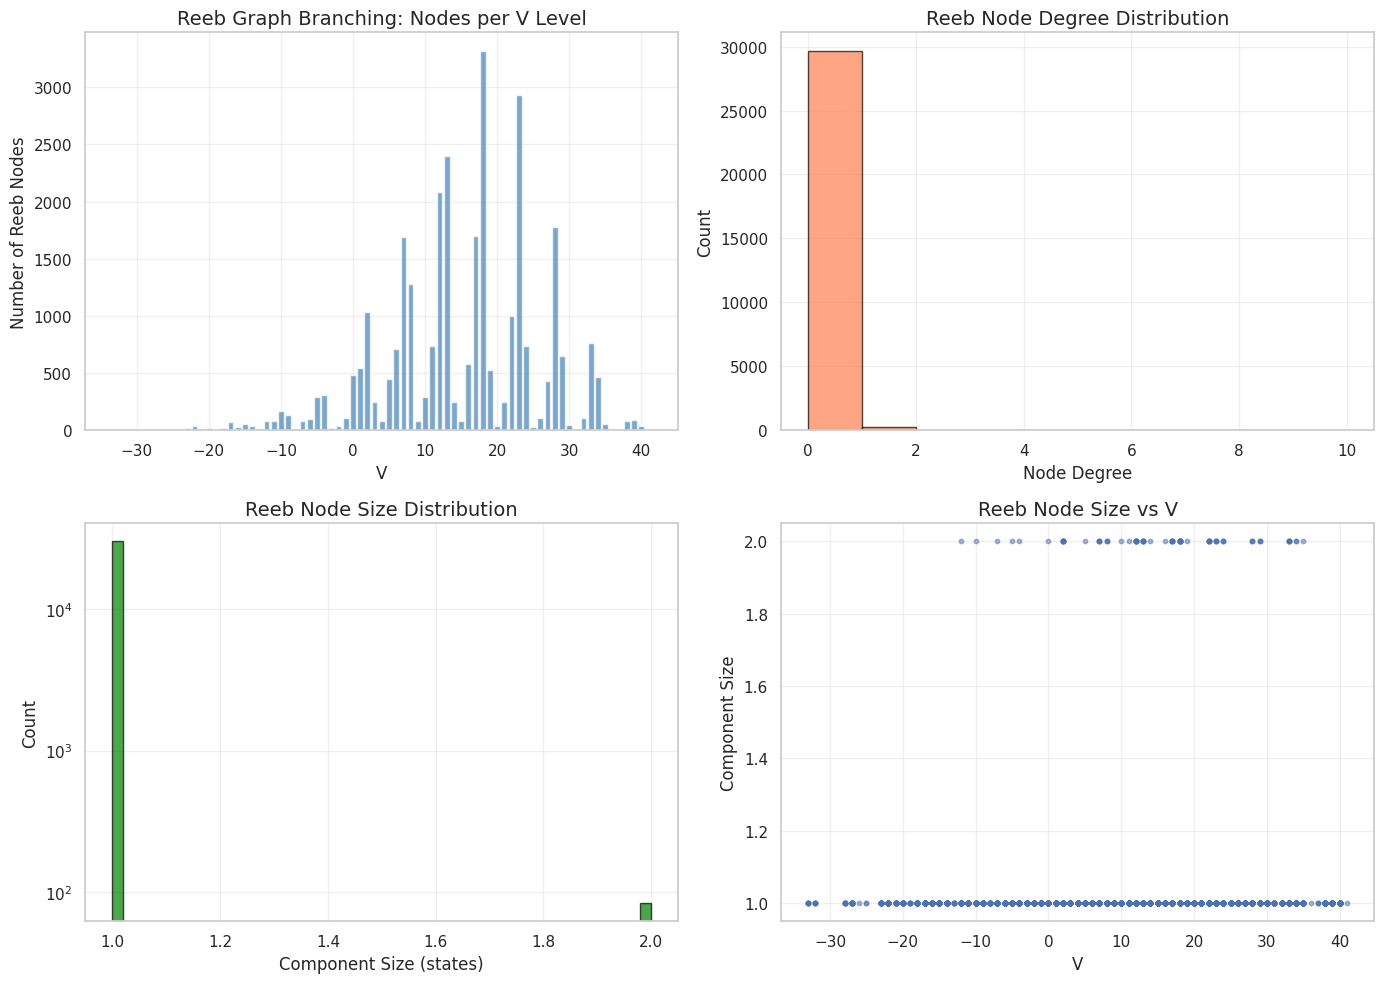

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Nodes per V value
axes[0, 0].bar(nodes_per_v.index, nodes_per_v.values, color='steelblue', alpha=0.7)
axes[0, 0].set_xlabel('V')
axes[0, 0].set_ylabel('Number of Reeb Nodes')
axes[0, 0].set_title('Reeb Graph Branching: Nodes per V Level')

# Node degree distribution
degrees = reeb_df['degree'].values
axes[0, 1].hist(degrees, bins=range(max(degrees)+2), color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Node Degree')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Reeb Node Degree Distribution')

# Node size distribution
axes[1, 0].hist(reeb_df['size'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Component Size (states)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Reeb Node Size Distribution')
axes[1, 0].set_yscale('log')

# Size vs V
axes[1, 1].scatter(reeb_df['v'], reeb_df['size'], alpha=0.5, s=10)
axes[1, 1].set_xlabel('V')
axes[1, 1].set_ylabel('Component Size')
axes[1, 1].set_title('Reeb Node Size vs V')

plt.tight_layout()
plt.savefig('../../results/figures/05b_reeb_structure.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Visualize Reeb Graph

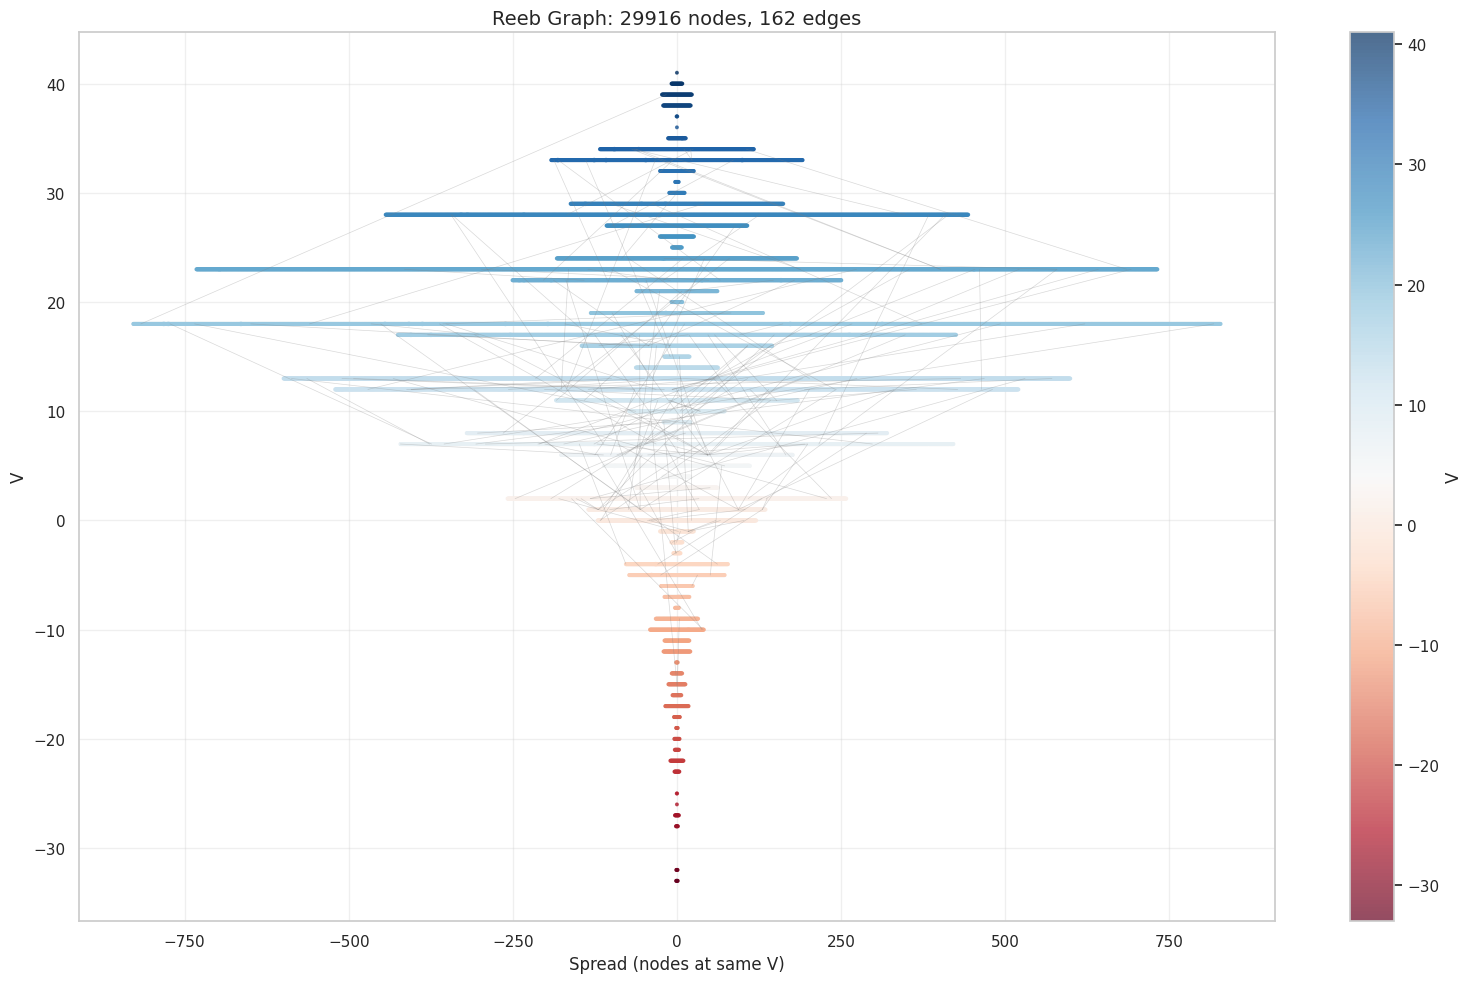

In [12]:
# Simple visualization: plot nodes at (x, v) where x spreads out nodes at same v
fig, ax = plt.subplots(figsize=(16, 10))

# Position nodes
node_positions = {}
v_counts = defaultdict(int)

for _, row in reeb_df.iterrows():
    v = row['v']
    node_id = row['node_id']
    
    # Spread nodes at same V horizontally
    n_at_v = nodes_per_v[v]
    idx_at_v = v_counts[v]
    v_counts[v] += 1
    
    if n_at_v == 1:
        x = 0
    else:
        x = (idx_at_v - (n_at_v - 1) / 2) * 0.5
    
    node_positions[node_id] = (x, v)

# Draw edges
for a, b in reeb_edges:
    x1, y1 = node_positions[a]
    x2, y2 = node_positions[b]
    ax.plot([x1, x2], [y1, y2], 'gray', alpha=0.3, linewidth=0.5)

# Draw nodes
xs = [node_positions[i][0] for i in range(len(reeb_nodes))]
ys = [node_positions[i][1] for i in range(len(reeb_nodes))]
sizes = np.log1p(reeb_df['size'].values) * 5
colors = reeb_df['v'].values

scatter = ax.scatter(xs, ys, c=colors, s=sizes, cmap='RdBu', alpha=0.7)
plt.colorbar(scatter, label='V')

ax.set_xlabel('Spread (nodes at same V)')
ax.set_ylabel('V')
ax.set_title(f'Reeb Graph: {len(reeb_nodes)} nodes, {len(reeb_edges)} edges')

plt.tight_layout()
plt.savefig('../../results/figures/05b_reeb_graph.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Critical Points Analysis

Critical points in the Reeb graph are where branching/merging occurs.

In [13]:
# Find V values where branching changes
branching_changes = []
sorted_v = sorted(nodes_per_v.index)

for i in range(1, len(sorted_v)):
    v_prev = sorted_v[i-1]
    v_curr = sorted_v[i]
    
    n_prev = nodes_per_v[v_prev]
    n_curr = nodes_per_v[v_curr]
    
    if n_curr != n_prev:
        branching_changes.append({
            'v': v_curr,
            'change': n_curr - n_prev,
            'type': 'branch' if n_curr > n_prev else 'merge',
            'nodes_before': n_prev,
            'nodes_after': n_curr,
        })

critical_df = pd.DataFrame(branching_changes)
print(f"Critical points (branching changes): {len(critical_df)}")
print(critical_df.head(20))

Critical points (branching changes): 70
     v  change    type  nodes_before  nodes_after
0  -32      -1   merge             6            5
1  -28       2  branch             5            7
2  -27       6  branch             7           13
3  -26     -12   merge            13            1
4  -25       1  branch             1            2
5  -23      14  branch             2           16
6  -22      25  branch            16           41
7  -21     -27   merge            41           14
8  -20       3  branch            14           17
9  -19     -11   merge            17            6
10 -18      13  branch             6           19
11 -17      53  branch            19           72
12 -16     -44   merge            72           28
13 -15      25  branch            28           53
14 -14     -20   merge            53           33
15 -13     -27   merge            33            6
16 -12      77  branch             6           83
17 -11      -6   merge            83           77
18 -10    

In [14]:
# Summary of critical points
n_branches = (critical_df['type'] == 'branch').sum()
n_merges = (critical_df['type'] == 'merge').sum()

print(f"\nCritical point summary:")
print(f"  Branch points: {n_branches}")
print(f"  Merge points: {n_merges}")
print(f"  Net change: {n_branches - n_merges}")


Critical point summary:
  Branch points: 41
  Merge points: 29
  Net change: 12


## Summary

In [15]:
summary = {
    'States analyzed': f"{len(states):,}",
    'Reeb nodes': len(reeb_nodes),
    'Reeb edges': len(reeb_edges),
    'Compression (states/nodes)': f"{len(states)/len(reeb_nodes):.1f}x",
    'V values': len(level_sets),
    'Mean nodes per V': f"{nodes_per_v.mean():.2f}",
    'Max branching': nodes_per_v.max(),
    'Critical points': len(critical_df),
}

print(viz.create_summary_table(summary, "Reeb Graph Summary"))

### Reeb Graph Summary

| Metric | Value |
|--------|-------|
| States analyzed | 30,000 |
| Reeb nodes | 29916 |
| Reeb edges | 162 |
| Compression (states/nodes) | 1.0x |
| V values | 71 |
| Mean nodes per V | 421.35 |
| Max branching | 3314 |
| Critical points | 70 |


In [16]:
# Save results
reeb_df.to_csv('../../results/tables/05b_reeb_nodes.csv', index=False)
if len(critical_df) > 0:
    critical_df.to_csv('../../results/tables/05b_critical_points.csv', index=False)
print("Results saved to results/tables/")

Results saved to results/tables/
